In [225]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tabulate import tabulate

In [231]:
def extract_info_from_path(path):
    """
    Extracts dataset name, author, context policy and model from the given path.
    """
    parts = path.split('/')
    name_parts = parts[-1].split('_')
    dataset_name = name_parts[0].replace('-',' ').capitalize()
    author = name_parts[1].capitalize() + " " + name_parts[2].capitalize()
    context_policy = name_parts[3].replace('-', ' ').capitalize()
    model = name_parts[4].replace('-',' ').replace('.csv','').capitalize()
    return dataset_name, author, model, context_policy

def compute_roc_values(auth1_df, auth2_df):
    """
    input: auth1_df, auth2_df holding response values over the same LM
    :return: ROC values where labels are 1 for auth1 and 0 for auth2, threshold is perplexity value and
    TP are all author1 responses with perplexity value above threshold
    FP are all author2 responses with perplexity value above threshold
    TN are all author2 responses with perplexity value below threshold
    FN are all author1 responses with perplexity value below threshold
    """
    labels = np.concatenate([np.zeros(len(auth1_df)), np.ones(len(auth2_df))])
    responses = np.concatenate([auth1_df['response'], auth2_df['response']])

    # Handle NaN values
    nan_mask = np.isnan(responses)
    labels = labels[~nan_mask]
    responses = responses[~nan_mask]

    fpr, tpr, _ = roc_curve(labels, responses)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

def calc_diff(auth1_path, auth2_path):
    """
    input: paths of author1 and author2 csv's holding responses for each sentence over the same LM
    output: Standardized Mean Difference between the authors responses (author1_log-ppx - author2_log-ppx)/pooled_std
    """
    auth1_df, auth2_df = pd.read_csv(auth1_path), pd.read_csv(auth2_path)
    auth1_mean, auth2_mean = auth1_df["response"].mean(), auth2_df["response"].mean()
    auth1_std, auth2_std = auth1_df["response"].std(), auth2_df["response"].std()
    len_auth1, len_auth2 = len(auth1_df), len(auth2_df)
    pooled_std = np.sqrt(((len_auth1-1) * auth1_std**2 + (len_auth2-1) * auth2_std**2)/ (len_auth1 + len_auth2 -2))
    diff = abs((auth1_mean - auth2_mean)/pooled_std)
    return diff

def lm_aggregate_metrics(lm_paths):
    """
    Compute AUC and standardized mean difference (calc_diff) for two use-cases:
    1. LM separator is one of the authors.
    2. LM separator is not one of the authors.
    
    :param paths: List paths containing the LM repsonses values over all authors
    :return: Results for both groups for each LM.
    """

    _, _, lm_name, _ = extract_info_from_path(lm_paths[0])
    group1_aucs, group1_diffs = [], [] # LM in authors
    group2_aucs, group2_diffs = [], [] # LM not in authors

    for i, auth1_path in enumerate(lm_paths):       # Iterate over authors
        for j, auth2_path in enumerate(lm_paths):
            if i >= j:                              # Avoid self-comparisons or duplicate pairs
                continue

            _, author1, _, _ = extract_info_from_path(auth1_path)
            _, author2, _, _ = extract_info_from_path(auth2_path)

            auth1_df = pd.read_csv(auth1_path)
            auth2_df = pd.read_csv(auth2_path)
            _, _, roc_auc = compute_roc_values(auth1_df, auth2_df)
            diff = calc_diff(auth1_path, auth2_path)

            # Check if the LM matches any part of the author names
            if any(keyword in author.lower() for keyword in lm_name.lower().split() for author in [author1, author2]):
                group1_aucs.append(roc_auc)
                group1_diffs.append(diff)
            else:
                group2_aucs.append(roc_auc)
                group2_diffs.append(diff)

    return group1_aucs, group1_diffs, group2_aucs, group2_diffs

def lm_comparison_table(group1_aucs, group1_diffs, group2_aucs, group2_diffs, lm_name):
    """ table preparation for per LM separator """
    avg_auc_in_authors = np.mean(group1_aucs) if group1_aucs else 0
    avg_diff_in_authors = np.mean(group1_diffs) if group1_diffs else 0
    avg_auc_not_in_authors = np.mean(group2_aucs) if group2_aucs else 0
    avg_diff_not_in_authors = np.mean(group2_diffs) if group2_diffs else 0
    return [lm_name, avg_auc_in_authors, avg_diff_in_authors, avg_auc_not_in_authors, avg_diff_not_in_authors]

def all_lms_comparison_table(group1_aucs, group1_diffs, group2_aucs, group2_diffs):
    """ table preparation for aggregate over all LMs """
    avg_auc_in_authors = np.mean(group1_aucs) if group1_aucs else 0
    avg_diff_in_authors = np.mean(group1_diffs) if group1_diffs else 0
    avg_auc_not_in_authors = np.mean(group2_aucs) if group2_aucs else 0
    avg_diff_not_in_authors = np.mean(group2_diffs) if group2_diffs else 0
    return ["All LMs", avg_auc_in_authors, avg_diff_in_authors, avg_auc_not_in_authors, avg_diff_not_in_authors]

def run_lm_comparison(paths):
    lm_comparison_results = []
    group1_aucs_all, group1_diffs_all, group2_aucs_all, group2_diffs_all = [], [], [], []
    for i, lm_paths in enumerate(paths):
        lm_is_author_aucs, lm_is_author_diffs, lm_not_author_aucs, lm_not_author_diffs = lm_aggregate_metrics(lm_paths)
        group1_aucs_all.extend(lm_is_author_aucs)
        group1_diffs_all.extend(lm_is_author_diffs)
        group2_aucs_all.extend(lm_not_author_aucs)
        group2_diffs_all.extend(lm_not_author_diffs)
        dataset, _, lm_name, _ = extract_info_from_path(lm_paths[0])

        lm_comparison_results.append(lm_comparison_table(lm_is_author_aucs, lm_is_author_diffs, lm_not_author_aucs, lm_not_author_diffs, lm_name))

    print(f"\n=== {dataset} Dataset ===")
    
    # first table (per LM separator)
    columns = ["LM Separator", "Avg AUC (LM in Authors)", "Avg Diff (LM in Authors)", "Avg AUC (LM not in Authors)", "Avg Diff (LM not in Authors)"]
    print("\nPer-LM Comparison")
    print(tabulate(lm_comparison_results, headers=columns, tablefmt="psql"))

    # second table (aggregate over all LMs)
    all_lms_table = all_lms_comparison_table(group1_aucs_all, group1_diffs_all, group2_aucs_all, group2_diffs_all)
    print("\nAll LMs Aggregate")
    print(tabulate([all_lms_table], headers=columns, tablefmt="psql"))
    return 

def compare_hist(auth1_path1, auth2_path1, auth1_path2, auth2_path2):
    """
    input: paths of author1 and author2 csv holding responses for each sentence
    output: histograms of author1 and author2 log-ppx values
    """
    auth1_df1 = pd.read_csv(auth1_path1)
    auth2_df1 = pd.read_csv(auth2_path1)
    auth1_df2 = pd.read_csv(auth1_path2)
    auth2_df2 = pd.read_csv(auth2_path2)

    dataset_name, author1, model1, _ = extract_info_from_path(auth1_path1)
    _, _, model2, _ = extract_info_from_path(auth1_path2)
    _, author2, _, _ = extract_info_from_path(auth2_path2)


    # Compute ROC values for each dataset
    fpr1, tpr1, roc_auc1 = compute_roc_values(auth1_df1, auth2_df1)
    fpr2, tpr2, roc_auc2 = compute_roc_values(auth1_df2, auth2_df2)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    bins = np.arange(min(auth1_df1["response"].min(), auth2_df1["response"].min(),auth1_df2["response"].min(), auth2_df2["response"].min()),
                max(auth1_df1["response"].max(), auth2_df1["response"].max(), auth1_df2["response"].max(), auth2_df2["response"].max()),
                     0.1)
    axs[0, 0].hist(auth1_df1["response"], bins=bins, alpha=0.5, label=author1)
    axs[0, 0].hist(auth2_df1["response"], bins=bins, alpha=0.5, label=author2)
    axs[0, 0].set_title(f"LM response generator - {model1}")
    axs[0, 0].set_xlabel('Log-perplexity')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].legend()

    axs[0, 1].hist(auth1_df2["response"], bins=bins, alpha=0.5, label=author1)
    axs[0, 1].hist(auth2_df2["response"], bins=bins, alpha=0.5, label=author2)
    axs[0, 1].set_title(f"LM response generator - {model2}")
    axs[0, 1].set_xlabel('Log-perplexity')
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].legend()

    # Plot the ROC curves using the computed values
    axs[1, 0].plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc1:.4f})')
    axs[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[1, 0].set_xlabel('False Positive Rate')
    axs[1, 0].set_ylabel('True Positive Rate')
    axs[1, 0].legend(loc='lower right')
    axs[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

    axs[1, 1].plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc2:.4f})')
    axs[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[1, 1].set_xlabel('False Positive Rate')
    axs[1, 1].set_ylabel('True Positive Rate')
    axs[1, 1].legend(loc='lower right')
    axs[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.suptitle(f"Dataset - {dataset_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [232]:
# Paths to csv's holding response values and sentence lengths
wiki_paths = [["Responses/wiki_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv", "Responses/wiki_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv", "Responses/wiki_human_text_none_Meta-Llama-3.1-8B-Instruct.csv"],
              ["Responses/wiki_Llama3.1_clean_none_falcon-7b.csv","Responses/wiki_Falcon_clean_none_falcon-7b.csv","Responses/wiki_human_text_none_falcon-7b.csv"],
              ["Responses/wiki_Llama3.1_clean_none_phi-2.csv","Responses/wiki_Falcon_clean_none_phi-2.csv","Responses/wiki_human_text_none_phi-2.csv"]]

news_paths = [["Responses/news_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv", "Responses/news_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv", "Responses/news_human_text_none_Meta-Llama-3.1-8B-Instruct.csv"],
              ["Responses/news_Llama3.1_clean_none_falcon-7b.csv","Responses/news_Falcon_clean_none_falcon-7b.csv","Responses/news_human_text_none_falcon-7b.csv"],
              ["Responses/news_Llama3.1_clean_none_phi-2.csv","Responses/news_Falcon_clean_none_phi-2.csv","Responses/news_human_text_none_phi-2.csv"]]

abstracts_paths = [["Responses/abstracts_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv", "Responses/abstracts_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv", "Responses/abstracts_human_text_none_Meta-Llama-3.1-8B-Instruct.csv"],
              ["Responses/abstracts_Llama3.1_clean_none_falcon-7b.csv","Responses/abstracts_Falcon_clean_none_falcon-7b.csv","Responses/abstracts_human_text_none_falcon-7b.csv"],
              ["Responses/abstracts_Llama3.1_clean_none_phi-2.csv","Responses/abstracts_Falcon_clean_none_phi-2.csv","Responses/abstracts_human_text_none_phi-2.csv"]]

In [233]:
print("=== Wiki Dataset ===")
group1_aucs, group1_diffs, group2_aucs, group2_diffs = [],[],[],[]
for i, lm_paths in enumerate(wiki_paths):
    lm_is_author_aucs, lm_is_author_diffs, lm_not_author_aucs, lm_not_author_diffs = lm_aggregate_metrics(lm_paths)
    group1_aucs.extend(lm_is_author_aucs)
    group1_diffs.extend(lm_is_author_diffs)
    group2_aucs.extend(lm_not_author_aucs)
    group2_diffs.extend(lm_not_author_diffs)
    _, _, lm_name, _ = extract_info_from_path(lm_paths[0])

    print(f"\nResults for {lm_name} separator:")
    print(f"LM-In-Authors:")
    print(f"    AUCs: {lm_is_author_aucs}")
    print(f"    Diffs: {lm_is_author_diffs}")
    print(f"LM-Not-In-Authors:")
    print(f"    AUCs: {lm_not_author_aucs}")
    print(f"    Diffs: {lm_not_author_diffs}")

=== Wiki Dataset ===

Results for Meta llama 3.1 8b instruct separator:
LM-In-Authors:
    AUCs: [0.7280384617832565, 0.8566496532093281]
    Diffs: [0.8958054352297985, 1.318738147864986]
LM-Not-In-Authors:
    AUCs: [0.5651484886311922]
    Diffs: [0.20797895579912196]

Results for Falcon 7b separator:
LM-In-Authors:
    AUCs: [0.5228595575644804, 0.6386770153434453]
    Diffs: [0.39068690145684726, 0.27705639029333007]
LM-Not-In-Authors:
    AUCs: [0.7656278682707988]
    Diffs: [1.0009922249755787]

Results for Phi 2 separator:
LM-In-Authors:
    AUCs: []
    Diffs: []
LM-Not-In-Authors:
    AUCs: [0.6857418023386905, 0.8765313068816863, 0.6161003725139518]
    Diffs: [0.7992703264118396, 1.4920149191460401, 0.11792622655456182]


In [234]:
run_lm_comparison(wiki_paths)
run_lm_comparison(news_paths)
run_lm_comparison(abstracts_paths)


=== Wiki Dataset ===

Per-LM Comparison
+----------------------------+---------------------------+----------------------------+-------------------------------+--------------------------------+
| LM Separator               |   Avg AUC (LM in Authors) |   Avg Diff (LM in Authors) |   Avg AUC (LM not in Authors) |   Avg Diff (LM not in Authors) |
|----------------------------+---------------------------+----------------------------+-------------------------------+--------------------------------|
| Meta llama 3.1 8b instruct |                  0.792344 |                   1.10727  |                      0.565148 |                       0.207979 |
| Falcon 7b                  |                  0.580768 |                   0.333872 |                      0.765628 |                       1.00099  |
| Phi 2                      |                  0        |                   0        |                      0.726124 |                       0.80307  |
+----------------------------+-----------

In [247]:
print("=== Wiki Dataset AUC by LM separator ===")

rows = [" G0 = Humans \n G1 = Llama3.1", " G0 = Humans\nG1 = Falcon"]
columns = ["Llama-3.1-8B-Instruct", "Falcon-7b", "Phi-2"]
results_table = []
for row_idx, pair in enumerate([[2, 0], [2, 1]]):  # Human vs Llama, Human vs Falcon
    row_results = []
    for col_idx, lm_paths in enumerate(wiki_paths):  # Each LM separator
        auth1_path = lm_paths[pair[0]]               # Human responses for this LM
        auth2_path = lm_paths[pair[1]]               # Llama or Falcon responses for this LM
        auth1_df = pd.read_csv(auth1_path)
        auth2_df = pd.read_csv(auth2_path)
        _, _, roc_auc = compute_roc_values(auth1_df, auth2_df)
        if (roc_auc<0.5):
            roc_auc = 1-roc_auc
        row_results.append(f"{roc_auc:.2f}")
    results_table.append(row_results)
print(tabulate(results_table, headers=columns, showindex=rows, tablefmt="grid", colalign=("center",)*(len(columns)+1)))


=== Wiki Dataset AUC by LM separator ===
+----------------+-------------------------+-------------+---------+
|                |  Llama-3.1-8B-Instruct  |  Falcon-7b  |  Phi-2  |
+================+=========================+=============+=========+
|  G0 = Humans   |          0.86           |    0.77     |  0.88   |
|  G1 = Llama3.1 |                         |             |         |
+----------------+-------------------------+-------------+---------+
|  G0 = Humans   |          0.57           |    0.64     |  0.62   |
|  G1 = Falcon   |                         |             |         |
+----------------+-------------------------+-------------+---------+


In [248]:
print("=== News Dataset ===")

rows = [" G0 = Humans \n G1 = Llama3.1", " G0 = Humans\nG1 = Falcon"]
columns = ["Llama-3.1-8B-Instruct", "Falcon-7b", "Phi-2"]
results_table = []
for row_idx, pair in enumerate([[2, 0], [2, 1]]):  # Human vs Llama, Human vs Falcon
    row_results = []
    for col_idx, lm_paths in enumerate(news_paths):  # Each LM separator
        auth1_path = lm_paths[pair[0]]               # Human responses for this LM
        auth2_path = lm_paths[pair[1]]               # Llama or Falcon responses for this LM
        auth1_df = pd.read_csv(auth1_path)
        auth2_df = pd.read_csv(auth2_path)
        _, _, roc_auc = compute_roc_values(auth1_df, auth2_df)
        if (roc_auc<0.5):
            roc_auc = 1-roc_auc
        row_results.append(f"{roc_auc:.2f}")
    results_table.append(row_results)
print(tabulate(results_table, headers=columns, showindex=rows, tablefmt="grid", colalign=("center",)*(len(columns)+1)))

=== News Dataset ===
+----------------+-------------------------+-------------+---------+
|                |  Llama-3.1-8B-Instruct  |  Falcon-7b  |  Phi-2  |
+================+=========================+=============+=========+
|  G0 = Humans   |          0.86           |    0.81     |  0.88   |
|  G1 = Llama3.1 |                         |             |         |
+----------------+-------------------------+-------------+---------+
|  G0 = Humans   |          0.61           |    0.67     |  0.65   |
|  G1 = Falcon   |                         |             |         |
+----------------+-------------------------+-------------+---------+


In [249]:
print("=== Abstracts Dataset ===")

rows = [" G0 = Humans \n G1 = Llama3.1", " G0 = Humans\nG1 = Falcon"]
columns = ["Llama-3.1-8B-Instruct", "Falcon-7b", "Phi-2"]
results_table = []
for row_idx, pair in enumerate([[2, 0], [2, 1]]):  # Human vs Llama, Human vs Falcon
    row_results = []
    for col_idx, lm_paths in enumerate(abstracts_paths):  # Each LM separator
        auth1_path = lm_paths[pair[0]]               # Human responses for this LM
        auth2_path = lm_paths[pair[1]]               # Llama or Falcon responses for this LM
        auth1_df = pd.read_csv(auth1_path)
        auth2_df = pd.read_csv(auth2_path)
        _, _, roc_auc = compute_roc_values(auth1_df, auth2_df)
        if (roc_auc<0.5):
            roc_auc = 1-roc_auc
        row_results.append(f"{roc_auc:.2f}")
    results_table.append(row_results)
print(tabulate(results_table, headers=columns, showindex=rows, tablefmt="grid", colalign=("center",)*(len(columns)+1)))

=== Abstracts Dataset ===
+----------------+-------------------------+-------------+---------+
|                |  Llama-3.1-8B-Instruct  |  Falcon-7b  |  Phi-2  |
+================+=========================+=============+=========+
|  G0 = Humans   |          0.76           |    0.72     |  0.81   |
|  G1 = Llama3.1 |                         |             |         |
+----------------+-------------------------+-------------+---------+
|  G0 = Humans   |          0.63           |     0.7     |  0.73   |
|  G1 = Falcon   |                         |             |         |
+----------------+-------------------------+-------------+---------+


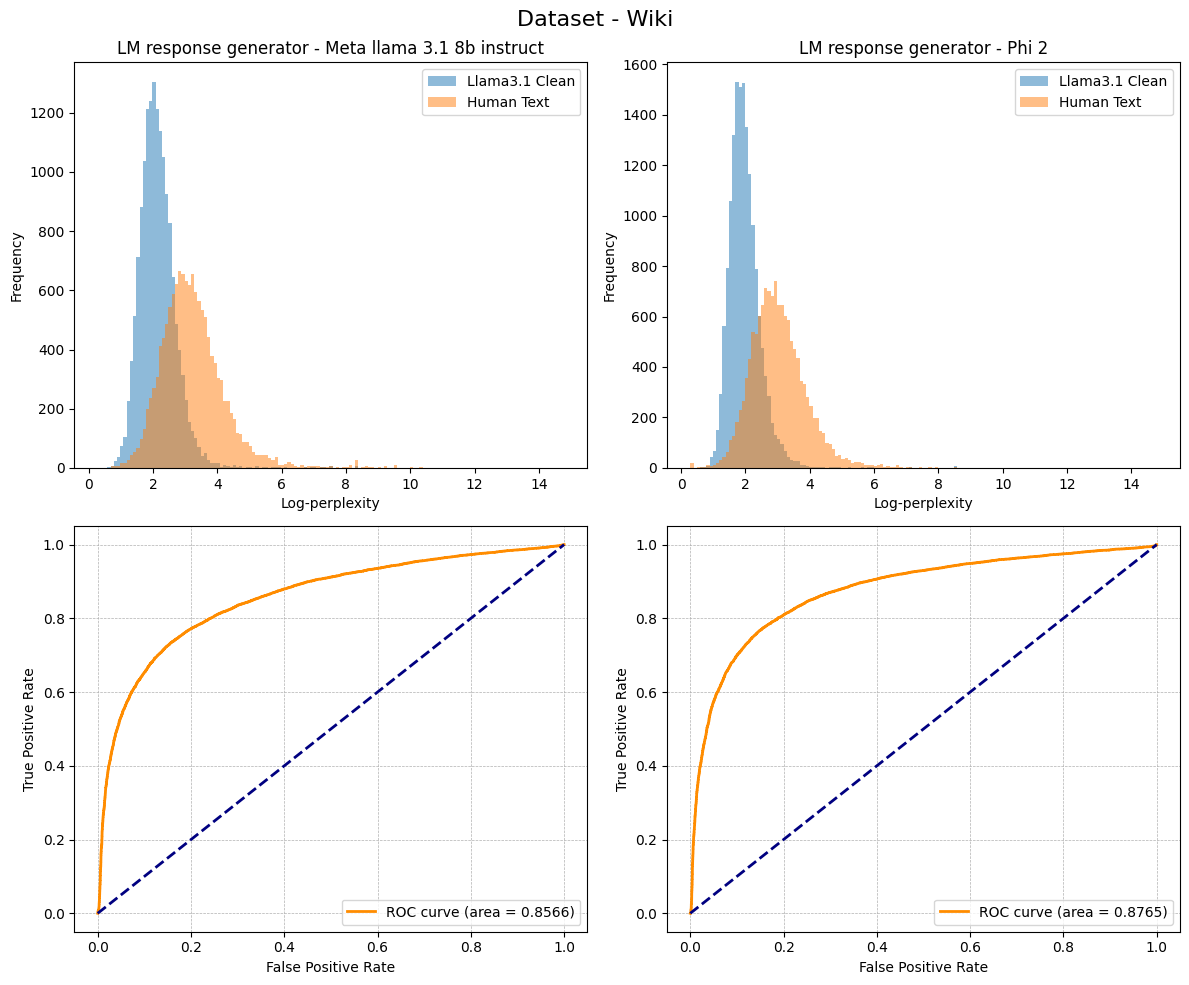

In [239]:
compare_hist('Responses/wiki_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/wiki_human_text_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/wiki_Llama3.1_clean_none_phi-2.csv', 
             'Responses/wiki_human_text_none_phi-2.csv')

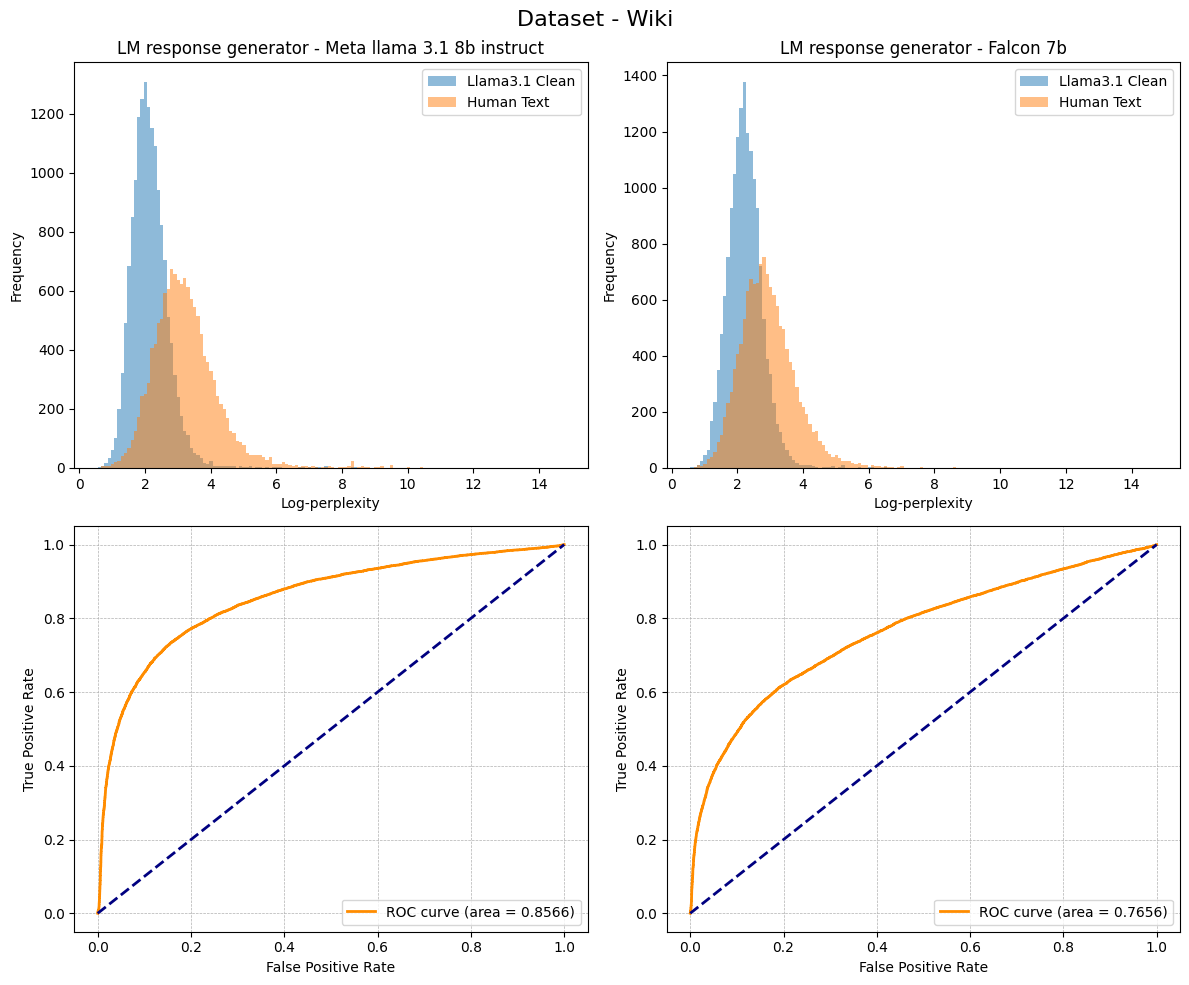

In [241]:
compare_hist('Responses/wiki_Llama3.1_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/wiki_human_text_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/wiki_Llama3.1_clean_none_falcon-7b.csv', 
             'Responses/wiki_human_text_none_falcon-7b.csv')

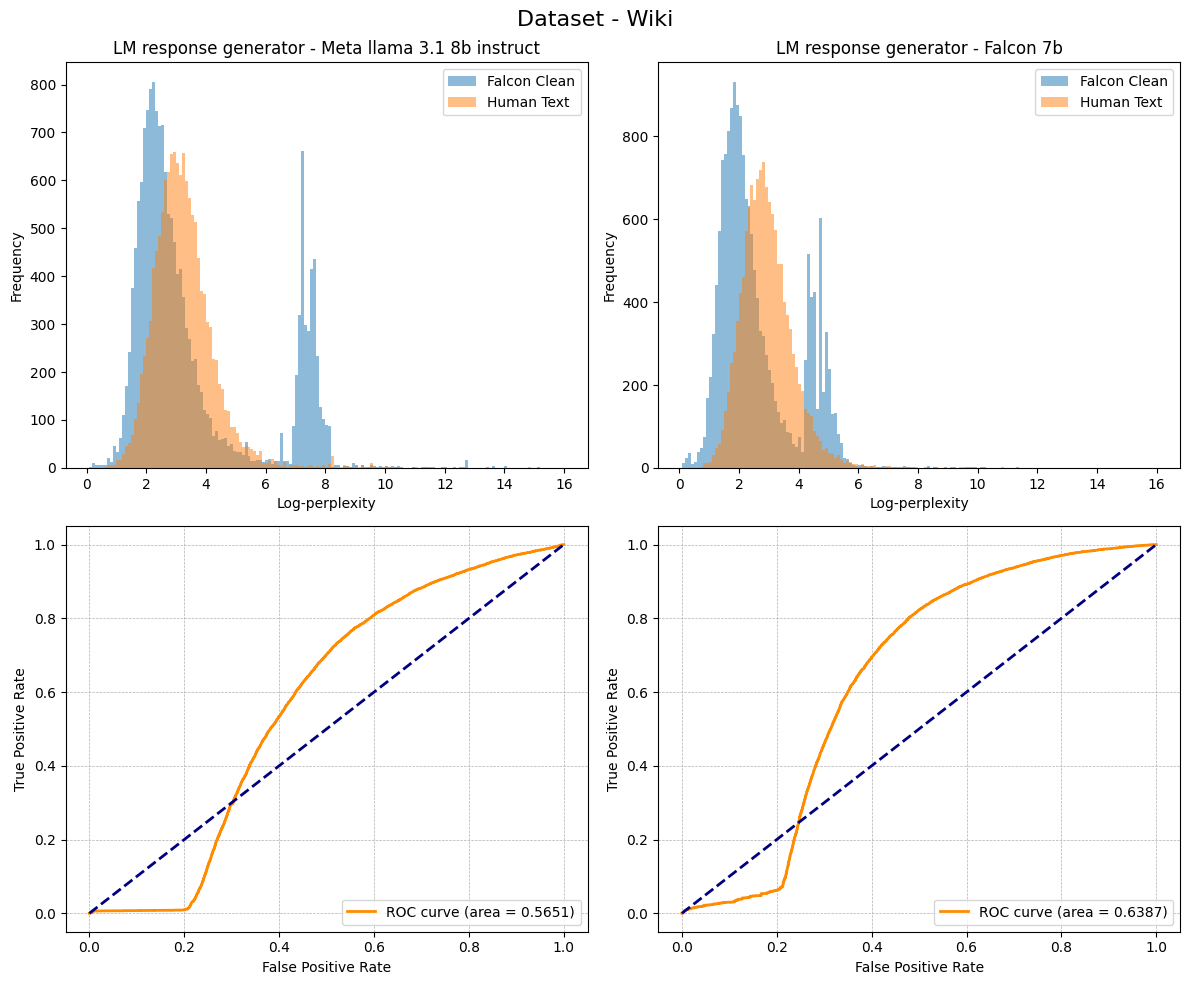

In [240]:
compare_hist('Responses/wiki_Falcon_clean_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/wiki_human_text_none_Meta-Llama-3.1-8B-Instruct.csv', 
             'Responses/wiki_Falcon_clean_none_falcon-7b.csv', 
             'Responses/wiki_human_text_none_falcon-7b.csv')